# Data and Library Importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report,f1_score

import time
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
from optuna.visualization import plot_pareto_front

from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input,Dense,concatenate,Dropout,Conv1D,Bidirectional,Embedding,LSTM,SimpleRNN,GlobalAveragePooling1D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.random import set_seed

In [2]:
set_seed(123)
np.random.seed(123)

In [3]:
label_latih=np.load('../input/emot-dataset/label_latih.npy', allow_pickle=True)
label_validasi=np.load('../input/emot-dataset/label_validasi.npy', allow_pickle=True)
label_uji=np.load('../input/emot-dataset/label_uji.npy', allow_pickle=True)

In [4]:
embedding_dim = 450
max_length = 80
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [5]:
teks_latih_pad=np.load('../input/emot-dataset/teks_latih_pad.npy', allow_pickle=True)
teks_latih=np.load('../input/emot-dataset/teks_latih.npy', allow_pickle=True)
teks_validasi_pad=np.load('../input/emot-dataset/teks_validasi_pad.npy', allow_pickle=True)
teks_validasi=np.load('../input/emot-dataset/teks_validasi.npy', allow_pickle=True)
teks_uji_pad=np.load('../input/emot-dataset/teks_uji_pad.npy', allow_pickle=True)
teks_uji=np.load('../input/emot-dataset/teks_uji.npy', allow_pickle=True)

# Modelling

## Baseline

In [6]:
jumlah_token=17039

In [7]:
inputs=Input(shape=(max_length,))
layers=Embedding(jumlah_token, embedding_dim,input_length=max_length,trainable=False)(inputs)
layers=Bidirectional(LSTM(16, return_sequences=True))(layers)
layers=Dropout(0.1)(layers)
layers=Bidirectional(LSTM(8))(layers)
layers=Dropout(0.1)(layers)
layers=Dense(8, activation='relu')(layers)
output=Dense(5, activation='softmax')(layers)

model=Model(inputs=[inputs],outputs=[output])

model.compile(optimizer=Adam(learning_rate=1e-3),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

2022-11-30 03:20:38.941059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:38.942030: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:39.276290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:39.277195: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:39.277959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 450)           7667550   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 32)            59776     
_________________________________________________________________
dropout (Dropout)            (None, 80, 32)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                2624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136   

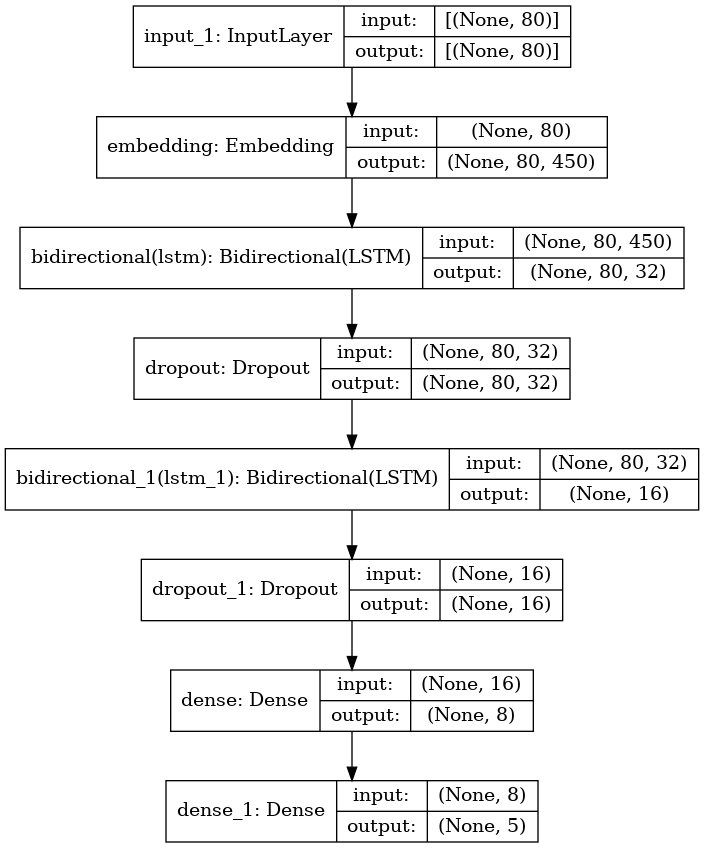

In [8]:
plot_model(model,to_file='./Baseline.png',show_shapes=True)

In [9]:
start=time.time()
history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,validation_data=(teks_validasi_pad,label_validasi),verbose=1)
end=time.time()

2022-11-30 03:20:47.217088: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-30 03:20:53.750104: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


221/221 [==============================] - 15s 22ms/step - loss: 1.5889 - accuracy: 0.2414 - val_loss: 1.5574 - val_accuracy: 0.2477
Epoch 2/25
221/221 [==============================] - 4s 20ms/step - loss: 1.4984 - accuracy: 0.2823 - val_loss: 1.4943 - val_accuracy: 0.3500
Epoch 3/25
221/221 [==============================] - 4s 17ms/step - loss: 1.4378 - accuracy: 0.3993 - val_loss: 1.4573 - val_accuracy: 0.3636
Epoch 4/25
221/221 [==============================] - 4s 17ms/step - loss: 1.3611 - accuracy: 0.4595 - val_loss: 1.3969 - val_accuracy: 0.4068
Epoch 5/25
221/221 [==============================] - 4s 17ms/step - loss: 1.2663 - accuracy: 0.5098 - val_loss: 1.3302 - val_accuracy: 0.4545
Epoch 6/25
221/221 [==============================] - 4s 16ms/step - loss: 1.1762 - accuracy: 0.5675 - val_loss: 1.3802 - val_accuracy: 0.4182
Epoch 7/25
221/221 [==============================] - 4s 16ms/step - loss: 1.1182 - accuracy: 0.5822 - val_loss: 1.3522 - val_accuracy: 0.4523
Epoch 8/2

<Figure size 432x288 with 0 Axes>

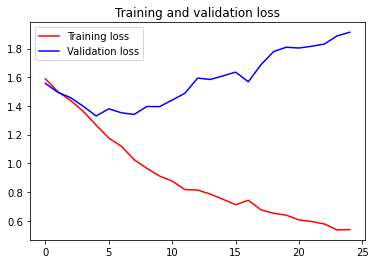

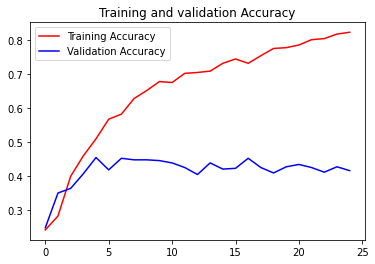

<Figure size 432x288 with 0 Axes>

In [10]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.figure()

In [11]:
model.save("EmoT Baseline model.h5")

In [12]:
Label_pred=model.predict(teks_uji_pad)
Label_pred

array([[5.75898252e-02, 1.64117962e-02, 8.85358691e-01, 1.26993321e-02,
        2.79403199e-02],
       [1.95988059e-01, 5.84639795e-02, 5.60646355e-01, 3.45526040e-02,
        1.50349021e-01],
       [5.07223271e-02, 5.86410999e-01, 2.39345571e-03, 1.06117525e-03,
        3.59412074e-01],
       ...,
       [1.46444440e-01, 4.88390103e-02, 6.67605221e-01, 3.12684886e-02,
        1.05842754e-01],
       [1.28604859e-01, 1.61750734e-01, 2.96943858e-02, 3.55251576e-03,
        6.76397562e-01],
       [6.14617802e-02, 1.39843911e-01, 7.80813303e-03, 7.85950222e-04,
        7.90100217e-01]], dtype=float32)

In [13]:
label_pred=Label_pred.argmax(axis=1)

In [14]:
print(classification_report(label_uji,label_pred))

              precision    recall  f1-score   support

           0       0.37      0.14      0.20       100
           1       0.49      0.42      0.45       110
           2       0.51      0.72      0.60        64
           3       0.77      0.37      0.50        65
           4       0.34      0.62      0.44       101

    accuracy                           0.44       440
   macro avg       0.50      0.45      0.44       440
weighted avg       0.47      0.44      0.42       440



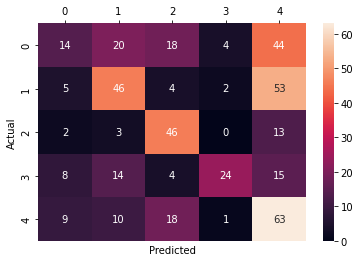

In [15]:
ax=sns.heatmap(confusion_matrix(label_uji,label_pred), annot = True)
ax.set(xlabel="Predicted",ylabel="Actual")
ax.xaxis.tick_top()

In [16]:
F1=f1_score(label_uji, label_pred, average='macro')
duration=end-start
print('Macro F1-score:',F1)
print("Duration:",duration)

Macro F1-score: 0.43789785554802696
Duration: 105.13960790634155


## BOHB (Usual Metric)

In [17]:
def create_model(trial):
  lstm_units=np.zeros(2, dtype=int)
  lstm_units[0]=trial.suggest_int("lstm_units_L1", 16, 48)
  lstm_units[1]=trial.suggest_int("lstm_units_L2", 4, 20)
  do1=trial.suggest_float("dropout_L1",0,0.5)
  do2=trial.suggest_float("dropout_L2",0,0.5)
  lr=trial.suggest_float("learning_rate",1e-5,1e-2)

  inputs=Input(shape=(max_length,))
  layers=Embedding(jumlah_token, embedding_dim,input_length=max_length,trainable=False)(inputs)
  layers=Bidirectional(LSTM(lstm_units[0], return_sequences=True))(layers)
  layers=Dropout(do1)(layers)
  layers=Bidirectional(LSTM(lstm_units[1]))(layers)
  layers=Dropout(do2)(layers)
  layers=Dense(8, activation='relu')(layers)
  output=Dense(5, activation='softmax')(layers)

  model=Model(inputs=[inputs],outputs=[output])

  model.compile(optimizer=Adam(learning_rate=lr),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

  return model

In [18]:
#Fungsi Objektif
def objective_fun(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  obj=((0.5*(-fscore))+(0.5*duration))
  model.save('BOHB (Usual Metric) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return obj

In [19]:
study=optuna.create_study(study_name="Multiobjective BOHB (Usual)",
                          direction="minimize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study.optimize(objective_fun,n_trials=25)

[I 2022-11-30 03:22:37,196] A new study created in memory with name: Multiobjective BOHB (Usual)
[I 2022-11-30 03:24:16,791] Trial 0 finished with value: 48.34665525430266 and parameters: {'lstm_units_L1': 41, 'lstm_units_L2': 7, 'dropout_L1': 0.0750829020459226, 'dropout_L2': 0.36383074837912704, 'learning_rate': 0.0025071658505441676}. Best is trial 0 with value: 48.34665525430266.


F1-Score: 0.4380359555517888
Duration: 97.1313464641571


[I 2022-11-30 03:25:00,603] Trial 1 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:26:41,246] Trial 2 finished with value: 47.67896559871135 and parameters: {'lstm_units_L1': 48, 'lstm_units_L2': 9, 'dropout_L1': 0.02462774421013708, 'dropout_L2': 0.3544632114249785, 'learning_rate': 0.008245458044521304}. Best is trial 2 with value: 47.67896559871135.


F1-Score: 0.5235943190873044
Duration: 95.88152551651001


[I 2022-11-30 03:28:17,256] Trial 3 finished with value: 46.72047935104035 and parameters: {'lstm_units_L1': 21, 'lstm_units_L2': 4, 'dropout_L1': 0.18081436514912258, 'dropout_L2': 0.25819900789645583, 'learning_rate': 0.003221482167933258}. Best is trial 3 with value: 46.72047935104035.


F1-Score: 0.4941640262670763
Duration: 93.93512272834778


[I 2022-11-30 03:29:55,187] Trial 4 finished with value: 47.6794731148702 and parameters: {'lstm_units_L1': 48, 'lstm_units_L2': 15, 'dropout_L1': 0.020861070825144767, 'dropout_L2': 0.2904410502930002, 'learning_rate': 0.0015230849468275199}. Best is trial 3 with value: 46.72047935104035.


F1-Score: 0.4941271287953753
Duration: 95.85307335853577


[I 2022-11-30 03:30:36,863] Trial 5 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:30:51,259] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:31:33,508] Trial 7 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:31:47,382] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:32:31,857] Trial 9 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:32:48,749] Trial 10 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:33:12,725] Trial 11 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:34:56,170] Trial 12 finished with value: 48.42232187803745 and parameters: {'lstm_units_L1': 37, 'lstm_units_L2': 14, 'dropout_L1': 0.06256604142248512, 'dropout_L2': 0.02326212067529615, 'learning_rate': 0.00021666933992756397}. Best is trial 3 with value: 46.72047935104035.


F1-Score: 0.4167731560039557
Duration: 97.26141691207886


[I 2022-11-30 03:35:40,566] Trial 13 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:36:25,301] Trial 14 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:37:11,793] Trial 15 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:38:48,861] Trial 16 finished with value: 47.3265753588693 and parameters: {'lstm_units_L1': 48, 'lstm_units_L2': 11, 'dropout_L1': 0.28083306132005426, 'dropout_L2': 0.48849407121080907, 'learning_rate': 0.0073799057058662266}. Best is trial 3 with value: 46.72047935104035.


F1-Score: 0.28894146251348085
Duration: 94.94209218025208


[I 2022-11-30 03:39:10,361] Trial 17 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:40:54,325] Trial 18 finished with value: 48.09775392916874 and parameters: {'lstm_units_L1': 29, 'lstm_units_L2': 10, 'dropout_L1': 0.32933039440571504, 'dropout_L2': 0.47148256789819765, 'learning_rate': 0.0010662110410653847}. Best is trial 3 with value: 46.72047935104035.


F1-Score: 0.39420547669975586
Duration: 96.58971333503723


[I 2022-11-30 03:41:08,022] Trial 19 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:41:51,121] Trial 20 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:42:05,558] Trial 21 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:43:44,955] Trial 22 finished with value: 47.782436592031566 and parameters: {'lstm_units_L1': 19, 'lstm_units_L2': 15, 'dropout_L1': 0.05113176288912252, 'dropout_L2': 0.4251525149374254, 'learning_rate': 0.005154485255509525}. Best is trial 3 with value: 46.72047935104035.


F1-Score: 0.5266173230627289
Duration: 96.09149050712585


[I 2022-11-30 03:43:58,757] Trial 23 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:44:12,936] Trial 24 pruned. Trial was pruned at epoch 1.


In [20]:
plot_optimization_history(study)

In [21]:
plot_intermediate_values(study)

In [22]:
plot_param_importances(study)

In [23]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  46.72047935104035
  Params: 
    lstm_units_L1: 21
    lstm_units_L2: 4
    dropout_L1: 0.18081436514912258
    dropout_L2: 0.25819900789645583
    learning_rate: 0.003221482167933258


## BOHB (Euclidean Metric)

In [24]:
#Fungsi Objektif
def objective_fun2(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  obj=((0.5*(-fscore)**2)+(0.5*(duration)**2))**0.5
  model.save('BOHB (Euclidean Metric) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return obj

In [25]:
study2=optuna.create_study(study_name="Multiobjective BOHB (Euclidean)",
                          direction="minimize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study2.optimize(objective_fun2,n_trials=25)

[I 2022-11-30 03:44:15,882] A new study created in memory with name: Multiobjective BOHB (Euclidean)
[I 2022-11-30 03:45:53,728] Trial 0 finished with value: 67.20284356972414 and parameters: {'lstm_units_L1': 47, 'lstm_units_L2': 20, 'dropout_L1': 0.07595458120848214, 'dropout_L2': 0.41743423960271503, 'learning_rate': 0.007072014211200404}. Best is trial 0 with value: 67.20284356972414.


F1-Score: 0.4447442139395248
Duration: 95.03813219070435


[I 2022-11-30 03:48:22,414] Trial 1 finished with value: 103.64735403530001 and parameters: {'lstm_units_L1': 31, 'lstm_units_L2': 5, 'dropout_L1': 0.31482075779951924, 'dropout_L2': 0.1647760594360902, 'learning_rate': 0.0014149974086967645}. Best is trial 0 with value: 67.20284356972414.


F1-Score: 0.48920758219757643
Duration: 146.57867741584778


[I 2022-11-30 03:49:05,489] Trial 2 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:49:23,343] Trial 3 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:51:02,909] Trial 4 finished with value: 67.5667997062062 and parameters: {'lstm_units_L1': 35, 'lstm_units_L2': 14, 'dropout_L1': 0.33641905159342955, 'dropout_L2': 0.1353017633272658, 'learning_rate': 0.005327304755850534}. Best is trial 0 with value: 67.20284356972414.


F1-Score: 0.49721977036674236
Duration: 95.55259084701538


[I 2022-11-30 03:51:16,173] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:51:39,608] Trial 6 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:52:00,599] Trial 7 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:52:14,408] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:52:35,160] Trial 9 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:54:12,072] Trial 10 finished with value: 67.1007164626373 and parameters: {'lstm_units_L1': 38, 'lstm_units_L2': 7, 'dropout_L1': 0.1956438387797486, 'dropout_L2': 0.3640940814307181, 'learning_rate': 0.0025390435600246043}. Best is trial 10 with value: 67.1007164626373.


F1-Score: 0.40041168831791946
Duration: 94.89389848709106


[I 2022-11-30 03:54:25,868] Trial 11 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:55:09,109] Trial 12 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:56:47,575] Trial 13 finished with value: 66.2219391707724 and parameters: {'lstm_units_L1': 24, 'lstm_units_L2': 18, 'dropout_L1': 0.29242067657698734, 'dropout_L2': 0.1835485303094928, 'learning_rate': 0.0046755633281500885}. Best is trial 13 with value: 66.2219391707724.


F1-Score: 0.527341931870944
Duration: 93.65047979354858


[I 2022-11-30 03:58:23,530] Trial 14 finished with value: 66.39161533561642 and parameters: {'lstm_units_L1': 48, 'lstm_units_L2': 18, 'dropout_L1': 0.04289624177174939, 'dropout_L2': 0.46587217099498, 'learning_rate': 0.0065354233943534625}. Best is trial 13 with value: 66.2219391707724.


F1-Score: 0.4926722058429376
Duration: 93.89063024520874


[I 2022-11-30 03:58:44,594] Trial 15 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:58:58,377] Trial 16 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:59:41,881] Trial 17 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:00:00,675] Trial 18 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:00:14,613] Trial 19 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:00:58,822] Trial 20 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:02:40,683] Trial 21 finished with value: 67.31672786802004 and parameters: {'lstm_units_L1': 44, 'lstm_units_L2': 9, 'dropout_L1': 0.36570311903455777, 'dropout_L2': 0.46485974347916886, 'learning_rate': 0.004750430509493966}. Best is trial 13 with value: 66.2219391707724.


F1-Score: 0.490802401347539
Duration: 95.1989643573761


[I 2022-11-30 04:03:01,898] Trial 22 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:03:20,456] Trial 23 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:04:04,984] Trial 24 pruned. Trial was pruned at epoch 9.


In [26]:
plot_optimization_history(study2)

In [27]:
plot_intermediate_values(study2)

In [28]:
plot_param_importances(study2)

In [29]:
print("Best trial:")
trial = study2.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  66.2219391707724
  Params: 
    lstm_units_L1: 24
    lstm_units_L2: 18
    dropout_L1: 0.29242067657698734
    dropout_L2: 0.1835485303094928
    learning_rate: 0.0046755633281500885


## BOHB (F1-score)

In [30]:
#Fungsi Objektif
def objective_fun_f1(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  model.save('BOHB (F1-score) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return fscore

In [31]:
study3=optuna.create_study(study_name="BOHB (F1-score)",
                          direction="maximize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study3.optimize(objective_fun_f1,n_trials=25)

[I 2022-11-30 04:04:06,714] A new study created in memory with name: BOHB (F1-score)
[I 2022-11-30 04:05:43,589] Trial 0 finished with value: 0.5044742756572779 and parameters: {'lstm_units_L1': 27, 'lstm_units_L2': 9, 'dropout_L1': 0.16331589506474592, 'dropout_L2': 0.002438934461205744, 'learning_rate': 0.002964031302851895}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.5044742756572779
Duration: 94.83047366142273


[I 2022-11-30 04:06:24,543] Trial 1 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:08:02,239] Trial 2 finished with value: 0.4855960505634146 and parameters: {'lstm_units_L1': 47, 'lstm_units_L2': 9, 'dropout_L1': 0.3663238622335289, 'dropout_L2': 0.16036347372411008, 'learning_rate': 0.004783633694664129}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.4855960505634146
Duration: 95.43934178352356


[I 2022-11-30 04:09:38,824] Trial 3 finished with value: 0.401863862601446 and parameters: {'lstm_units_L1': 23, 'lstm_units_L2': 9, 'dropout_L1': 0.09901139773388218, 'dropout_L2': 0.26977965291994105, 'learning_rate': 0.0003992776307324612}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.401863862601446
Duration: 94.46074390411377


[I 2022-11-30 04:11:15,411] Trial 4 finished with value: 0.08 and parameters: {'lstm_units_L1': 32, 'lstm_units_L2': 13, 'dropout_L1': 0.305781703440957, 'dropout_L2': 0.1603039910719961, 'learning_rate': 0.004725174543663399}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.08
Duration: 94.49242115020752


[I 2022-11-30 04:12:52,243] Trial 5 finished with value: 0.45922836143491974 and parameters: {'lstm_units_L1': 44, 'lstm_units_L2': 10, 'dropout_L1': 0.28338161925248145, 'dropout_L2': 0.2463484824492742, 'learning_rate': 0.009200493626750775}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.45922836143491974
Duration: 94.4298083782196


[I 2022-11-30 04:13:06,153] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:13:20,852] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:13:36,616] Trial 8 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:15:15,771] Trial 9 finished with value: 0.4873580700538585 and parameters: {'lstm_units_L1': 39, 'lstm_units_L2': 7, 'dropout_L1': 0.2693432397871504, 'dropout_L2': 0.032011363419340966, 'learning_rate': 0.006523284725999882}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.4873580700538585
Duration: 95.20124888420105


[I 2022-11-30 04:16:52,276] Trial 10 finished with value: 0.33980631809321216 and parameters: {'lstm_units_L1': 44, 'lstm_units_L2': 15, 'dropout_L1': 0.2904519055566077, 'dropout_L2': 0.3393513382167756, 'learning_rate': 0.005935625527135421}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.33980631809321216
Duration: 94.40270471572876


[I 2022-11-30 04:17:05,840] Trial 11 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:17:28,712] Trial 12 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:17:43,472] Trial 13 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:18:26,760] Trial 14 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:18:45,288] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:19:08,823] Trial 16 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:20:45,347] Trial 17 finished with value: 0.46062529971018884 and parameters: {'lstm_units_L1': 26, 'lstm_units_L2': 18, 'dropout_L1': 0.457919079742516, 'dropout_L2': 0.42973523584037304, 'learning_rate': 0.0019643173875089114}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.46062529971018884
Duration: 94.40499639511108


[I 2022-11-30 04:20:59,178] Trial 18 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:21:22,024] Trial 19 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:22:08,101] Trial 20 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:22:34,113] Trial 21 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:23:20,597] Trial 22 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:24:56,030] Trial 23 finished with value: 0.46209380456518157 and parameters: {'lstm_units_L1': 45, 'lstm_units_L2': 16, 'dropout_L1': 0.03538662131640552, 'dropout_L2': 0.22538196697813717, 'learning_rate': 0.00042047805155866316}. Best is trial 0 with value: 0.5044742756572779.


F1-Score: 0.46209380456518157
Duration: 93.35522627830505


[I 2022-11-30 04:25:36,308] Trial 24 pruned. Trial was pruned at epoch 9.


In [32]:
plot_optimization_history(study3)

In [33]:
plot_intermediate_values(study3)

In [34]:
plot_param_importances(study3)

In [35]:
print("Best trial:")
trial = study3.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.5044742756572779
  Params: 
    lstm_units_L1: 27
    lstm_units_L2: 9
    dropout_L1: 0.16331589506474592
    dropout_L2: 0.002438934461205744
    learning_rate: 0.002964031302851895


## BOHB (Time)

In [36]:
#Fungsi Objektif
def objective_fun_time(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  model.save('BOHB (Time) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return duration

In [37]:
study4=optuna.create_study(study_name="BOHB (Time)",
                          direction="minimize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study4.optimize(objective_fun_time,n_trials=25)

[I 2022-11-30 04:25:43,322] A new study created in memory with name: BOHB (Time)
[I 2022-11-30 04:27:20,175] Trial 0 finished with value: 94.00717067718506 and parameters: {'lstm_units_L1': 46, 'lstm_units_L2': 11, 'dropout_L1': 0.34954004092549856, 'dropout_L2': 0.41645651575481984, 'learning_rate': 0.0038014999342491883}. Best is trial 0 with value: 94.00717067718506.


F1-Score: 0.4974627326328453
Duration: 94.00717067718506


[I 2022-11-30 04:28:55,965] Trial 1 finished with value: 93.49641394615173 and parameters: {'lstm_units_L1': 19, 'lstm_units_L2': 20, 'dropout_L1': 0.2003200683838583, 'dropout_L2': 0.3261532119292385, 'learning_rate': 0.0037007195130879045}. Best is trial 1 with value: 93.49641394615173.


F1-Score: 0.484385734995595
Duration: 93.49641394615173


[I 2022-11-30 04:29:10,205] Trial 2 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:30:47,552] Trial 3 finished with value: 93.8786506652832 and parameters: {'lstm_units_L1': 35, 'lstm_units_L2': 15, 'dropout_L1': 0.07325825135079594, 'dropout_L2': 0.3535156011466062, 'learning_rate': 0.0035162059241608972}. Best is trial 1 with value: 93.49641394615173.


F1-Score: 0.5294461446470861
Duration: 93.8786506652832


[I 2022-11-30 04:33:16,343] Trial 4 finished with value: 146.6652283668518 and parameters: {'lstm_units_L1': 35, 'lstm_units_L2': 11, 'dropout_L1': 0.47218868097371985, 'dropout_L2': 0.15882377374802892, 'learning_rate': 0.005307382193904409}. Best is trial 1 with value: 93.49641394615173.


F1-Score: 0.462627853723572
Duration: 146.6652283668518


[I 2022-11-30 04:33:29,521] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:35:06,926] Trial 6 finished with value: 94.41291642189026 and parameters: {'lstm_units_L1': 41, 'lstm_units_L2': 18, 'dropout_L1': 0.16256331161727178, 'dropout_L2': 0.15680962144145616, 'learning_rate': 0.00025240764287201567}. Best is trial 1 with value: 93.49641394615173.


F1-Score: 0.4986096259384419
Duration: 94.41291642189026


[I 2022-11-30 04:35:21,809] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:37:51,691] Trial 8 finished with value: 146.61241364479065 and parameters: {'lstm_units_L1': 29, 'lstm_units_L2': 10, 'dropout_L1': 0.2535676709023092, 'dropout_L2': 0.04796136764495673, 'learning_rate': 0.005412428715802578}. Best is trial 1 with value: 93.49641394615173.


F1-Score: 0.47771084275849207
Duration: 146.61241364479065


[I 2022-11-30 04:38:13,293] Trial 9 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:38:34,648] Trial 10 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:38:59,625] Trial 11 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:39:18,894] Trial 12 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:39:41,964] Trial 13 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:39:59,350] Trial 14 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:40:22,898] Trial 15 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:40:49,385] Trial 16 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:41:04,118] Trial 17 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:41:46,518] Trial 18 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:42:29,727] Trial 19 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:43:12,160] Trial 20 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:43:36,364] Trial 21 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:43:55,833] Trial 22 pr

In [38]:
plot_optimization_history(study4)

In [39]:
plot_intermediate_values(study4)

In [40]:
plot_param_importances(study4)

In [41]:
print("Best trial:")
trial = study4.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  93.49641394615173
  Params: 
    lstm_units_L1: 19
    lstm_units_L2: 20
    dropout_L1: 0.2003200683838583
    dropout_L2: 0.3261532119292385
    learning_rate: 0.0037007195130879045
